# T1/T2 MRI CycleGAN s U-Net Generatorima

Ova bilježnica implementira CycleGAN model za transformaciju između T1 i T2 MRI snimaka. Koristi U-Net arhitekturu za generatore kako bi se postigli bolji rezultati u očuvanju strukture.

In [1]:
!nvidia-smi


Fri May  9 13:16:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   37C    P5             18W /   80W |     469MiB /   6144MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Postavljanje okruženja i uvoz bibliteka

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torch.backends.cudnn as cudnn
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import datetime
import json

# Postavljanje random seed-a za reproducibilnost
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    # Omogućavanje CUDNN benchmarkinga za brže treniranje
    cudnn.benchmark = True
# Provjera dostupnosti GPU-a
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Koristim uređaj: {device}")
# Ako je dostupan CUDA, ispiši informacije o GPU-u
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memorija: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


Koristim uređaj: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Memorija: 6.19 GB


In [30]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from utils.models import VGG19Generator
from utils.config import CycleGANConfig
from utils.dataset import get_stratified_data_loaders
from utils.train import train_cyclegan
from utils.test import test_model
from utils.visualization import visualize_results, plot_training_curves


In [18]:
config = CycleGANConfig(
    t1_dir="../dataset/data/images/t1",  # Prilagodite putanju prema vašim podacima
    t2_dir="../dataset/data/images/t2",  # Prilagodite putanju prema vašim podacima
    results_dir="../rezultati/vgg19_model",
    checkpoints_dir="../checkpoints/vgg19_model",
    batch_size=2,  # Smanjite za manje GPU memorije
    lr=0.0001,
    beta1=0.5,
    beta2=0.999,
    n_epochs=200,  # Prilagodite broj epoha prema potrebi
    decay_epoch=75,  # Learning rate počinje opadati nakon ove epohe
    img_size=256,
    input_channels=1,  # MRI slike su sive (1 kanal)
    output_channels=1,
    ngf=64,  # Broj filtera u generatoru
    ndf=64,  # Broj filtera u diskriminatoru
    lambda_A=15.0,  # Težina cycle loss-a za T1->T2->T1
    lambda_B=15.0,  # Težina cycle loss-a za T2->T1->T2
    lambda_identity=0.1,  # Težina identity loss-a
    architecture="vgg19",  # Koristimo standardnu arhitekturu
    sample_interval=50,  # Vizualiziraj slike svakih 5 epoha
    checkpoint_interval=50,  # Spremi checkpoint svakih 10 epoha
    device=None  # Automatski odabir (GPU ako je dostupan, inače CPU)
)

In [19]:
# Ispiši konfiguraciju
config.print_config()


=== Konfiguracija modela ===
Arhitektura: vgg19
T1 direktorij: ../dataset/data/images/t1
T2 direktorij: ../dataset/data/images/t2
Batch veličina: 2
Learning rate: 0.0001
Broj epoha: 200
Veličina slike: 256x256
Broj filtera u generatoru: 64
Broj filtera u diskriminatoru: 64
Lambda A: 15.0
Lambda B: 15.0
Lambda identity: 0.1
Uređaj: cuda



In [20]:
# Lista posebnih ID-ova za stratificiranu podjelu (ID-ovi "mutnijih" slika)
special_ids = [
    '035', '230', '231', '232', '233', '234', '238', '290', '291', '292', 
    '293', '294', '303', '305', '306', '307', '310', '314', '315', '322', 
    '331', '332', '333', '337', '340', '345', '347', '371', '372', '373', 
    '378', '382', '388', '395', '423', '424', '425', '426', '427', '430', 
    '433', '434', '435', '442', '462', '463', '464', '469', '470', '473', 
    '474', '475', '476', '477', '478', '510', '517', '532', '541', '542', 
    '543', '547', '548', '553', '561', '563', '571', '573', '574', '588', 
    '595', '596', '597'
]

print(f"Broj posebnih ID-ova: {len(special_ids)}")

train_dataloader, val_dataloader, test_dataloader = get_stratified_data_loaders(
    config=config,
    special_ids=special_ids,
    train_ratio=0.8,
    val_ratio=0.05,
    test_ratio=0.15
)

Broj posebnih ID-ova: 73
Pronađeno 572 T1 slika i 572 T2 slika
Pronađeno 572 sparenih T1/T2 slika
Pronađeno 69 posebnih slika i 503 regularnih slika.
Podjela posebnih slika: 55 trening, 3 validacija, 11 test
Podjela regularnih slika: 402 trening, 25 validacija, 76 test
Ukupna podjela: 457 trening, 28 validacija, 87 test


In [21]:
# Zatim očisti CUDA cache
import torch
torch.cuda.empty_cache()

# Opcionalno, pozovi garbage collector
import gc
gc.collect()

0

In [22]:
G_AB, G_BA, train_history, best_val_loss = train_cyclegan(
    config=config,
    use_test_split=True,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader
)

Epoha 1/200: 100%|██████████| 229/229 [01:36<00:00,  2.37it/s, D_A_loss=0.0318, D_B_loss=0.0836, G_loss=12.5661]


Epoha 1/200 - Train gubici: G: 14.0786, D_A: 0.1809, D_B: 0.2292 | Val gubici: G: 12.0954, Cycle: 10.4177
Novi najbolji validacijski gubitak: 10.4177, spremam modele...


Epoha 2/200: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A_loss=0.0150, D_B_loss=0.0944, G_loss=11.8895]


Epoha 2/200 - Train gubici: G: 12.0762, D_A: 0.0267, D_B: 0.0924 | Val gubici: G: 11.1389, Cycle: 9.3232
Novi najbolji validacijski gubitak: 9.3232, spremam modele...


Epoha 3/200: 100%|██████████| 229/229 [01:32<00:00,  2.47it/s, D_A_loss=0.0879, D_B_loss=0.0251, G_loss=4.9114]


Epoha 3/200 - Train gubici: G: 7.6231, D_A: 0.1171, D_B: 0.0429 | Val gubici: G: 5.0057, Cycle: 3.5038
Novi najbolji validacijski gubitak: 3.5038, spremam modele...


Epoha 4/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0768, D_B_loss=0.0942, G_loss=4.0383]


Epoha 4/200 - Train gubici: G: 4.6986, D_A: 0.0837, D_B: 0.0578 | Val gubici: G: 4.8153, Cycle: 3.3452
Novi najbolji validacijski gubitak: 3.3452, spremam modele...


Epoha 5/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0802, D_B_loss=0.0754, G_loss=3.9127]


Epoha 5/200 - Train gubici: G: 4.2058, D_A: 0.0633, D_B: 0.0787 | Val gubici: G: 4.6692, Cycle: 2.6435
Novi najbolji validacijski gubitak: 2.6435, spremam modele...


Epoha 6/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1544, D_B_loss=0.1704, G_loss=3.6885]


Epoha 6/200 - Train gubici: G: 4.0626, D_A: 0.1179, D_B: 0.0664 | Val gubici: G: 3.6124, Cycle: 2.6263
Novi najbolji validacijski gubitak: 2.6263, spremam modele...


Epoha 7/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1310, D_B_loss=0.0228, G_loss=3.7896]


Epoha 7/200 - Train gubici: G: 3.6631, D_A: 0.1646, D_B: 0.0712 | Val gubici: G: 3.1512, Cycle: 2.0800
Novi najbolji validacijski gubitak: 2.0800, spremam modele...


Epoha 8/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1607, D_B_loss=0.2650, G_loss=3.4216]


Epoha 8/200 - Train gubici: G: 3.6216, D_A: 0.1468, D_B: 0.0854 | Val gubici: G: 3.1413, Cycle: 2.3687


Epoha 9/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1968, D_B_loss=0.1952, G_loss=3.1694]


Epoha 9/200 - Train gubici: G: 3.5253, D_A: 0.1441, D_B: 0.1007 | Val gubici: G: 2.5867, Cycle: 2.0467
Novi najbolji validacijski gubitak: 2.0467, spremam modele...


Epoha 10/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.2639, D_B_loss=0.0908, G_loss=3.7190]


Epoha 10/200 - Train gubici: G: 3.2563, D_A: 0.1341, D_B: 0.1123 | Val gubici: G: 2.8408, Cycle: 1.5680
Novi najbolji validacijski gubitak: 1.5680, spremam modele...


Epoha 11/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0822, D_B_loss=0.0767, G_loss=2.8598]


Epoha 11/200 - Train gubici: G: 3.1809, D_A: 0.1129, D_B: 0.1075 | Val gubici: G: 3.1047, Cycle: 1.7734


Epoha 12/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0941, D_B_loss=0.0774, G_loss=3.5222]


Epoha 12/200 - Train gubici: G: 3.2534, D_A: 0.1036, D_B: 0.0945 | Val gubici: G: 3.1253, Cycle: 1.9276


Epoha 13/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0747, D_B_loss=0.0698, G_loss=3.3444]


Epoha 13/200 - Train gubici: G: 3.3003, D_A: 0.0932, D_B: 0.0964 | Val gubici: G: 3.3843, Cycle: 1.8642


Epoha 14/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0821, D_B_loss=0.0433, G_loss=2.9983]


Epoha 14/200 - Train gubici: G: 3.4357, D_A: 0.0943, D_B: 0.0944 | Val gubici: G: 3.6021, Cycle: 2.1005


Epoha 15/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1042, D_B_loss=0.0716, G_loss=3.1005]


Epoha 15/200 - Train gubici: G: 3.3320, D_A: 0.0900, D_B: 0.0919 | Val gubici: G: 3.5031, Cycle: 1.8737


Epoha 16/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0686, D_B_loss=0.0552, G_loss=4.6641]


Epoha 16/200 - Train gubici: G: 3.3788, D_A: 0.0752, D_B: 0.0918 | Val gubici: G: 3.3379, Cycle: 2.0000


Epoha 17/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0704, D_B_loss=0.2382, G_loss=2.3769]


Epoha 17/200 - Train gubici: G: 3.3467, D_A: 0.0727, D_B: 0.0861 | Val gubici: G: 3.7790, Cycle: 1.9240


Epoha 18/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0826, D_B_loss=0.1152, G_loss=5.2269]


Epoha 18/200 - Train gubici: G: 3.3219, D_A: 0.0808, D_B: 0.0869 | Val gubici: G: 3.4151, Cycle: 2.1336


Epoha 19/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1010, D_B_loss=0.0446, G_loss=3.0415]


Epoha 19/200 - Train gubici: G: 3.3179, D_A: 0.0720, D_B: 0.0878 | Val gubici: G: 3.6973, Cycle: 1.7885


Epoha 20/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0348, D_B_loss=0.0497, G_loss=3.0953]


Epoha 20/200 - Train gubici: G: 3.2854, D_A: 0.0744, D_B: 0.0908 | Val gubici: G: 3.1156, Cycle: 1.7783


Epoha 21/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0595, D_B_loss=0.0653, G_loss=2.7258]


Epoha 21/200 - Train gubici: G: 3.2329, D_A: 0.0734, D_B: 0.0894 | Val gubici: G: 4.0501, Cycle: 1.9385


Epoha 22/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0564, D_B_loss=0.1053, G_loss=3.1969]


Epoha 22/200 - Train gubici: G: 3.2082, D_A: 0.0735, D_B: 0.0902 | Val gubici: G: 3.6708, Cycle: 1.8402


Epoha 23/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0667, D_B_loss=0.0923, G_loss=3.6192]


Epoha 23/200 - Train gubici: G: 3.1700, D_A: 0.0766, D_B: 0.0930 | Val gubici: G: 3.3808, Cycle: 1.6488


Epoha 24/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1127, D_B_loss=0.1189, G_loss=2.9572]


Epoha 24/200 - Train gubici: G: 3.1429, D_A: 0.0733, D_B: 0.0870 | Val gubici: G: 2.2124, Cycle: 1.7342


Epoha 25/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0598, D_B_loss=0.0893, G_loss=2.6460]


Epoha 25/200 - Train gubici: G: 3.0721, D_A: 0.0784, D_B: 0.0957 | Val gubici: G: 3.4593, Cycle: 1.9327


Epoha 26/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0556, D_B_loss=0.1188, G_loss=2.8235]


Epoha 26/200 - Train gubici: G: 3.0792, D_A: 0.0740, D_B: 0.0867 | Val gubici: G: 2.5353, Cycle: 1.6666


Epoha 27/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0633, D_B_loss=0.0633, G_loss=2.6952]


Epoha 27/200 - Train gubici: G: 3.0553, D_A: 0.0785, D_B: 0.0894 | Val gubici: G: 3.0670, Cycle: 1.6176


Epoha 28/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1232, D_B_loss=0.1128, G_loss=3.0518]


Epoha 28/200 - Train gubici: G: 3.0321, D_A: 0.0696, D_B: 0.0923 | Val gubici: G: 2.8743, Cycle: 1.5986


Epoha 29/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0367, D_B_loss=0.0770, G_loss=2.7506]


Epoha 29/200 - Train gubici: G: 3.0510, D_A: 0.0777, D_B: 0.0871 | Val gubici: G: 3.2701, Cycle: 1.5608
Novi najbolji validacijski gubitak: 1.5608, spremam modele...


Epoha 30/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0201, D_B_loss=0.1091, G_loss=2.5342]


Epoha 30/200 - Train gubici: G: 3.0669, D_A: 0.0705, D_B: 0.0807 | Val gubici: G: 3.0342, Cycle: 1.7463


Epoha 31/200: 100%|██████████| 229/229 [01:28<00:00,  2.58it/s, D_A_loss=0.1885, D_B_loss=0.0369, G_loss=2.6691]


Epoha 31/200 - Train gubici: G: 3.0451, D_A: 0.1049, D_B: 0.0817 | Val gubici: G: 2.9206, Cycle: 1.6538


Epoha 32/200: 100%|██████████| 229/229 [01:28<00:00,  2.58it/s, D_A_loss=0.0483, D_B_loss=0.0716, G_loss=3.9714]


Epoha 32/200 - Train gubici: G: 3.0315, D_A: 0.0780, D_B: 0.0778 | Val gubici: G: 2.6920, Cycle: 1.6796


Epoha 33/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0874, D_B_loss=0.0501, G_loss=2.6248]


Epoha 33/200 - Train gubici: G: 3.0409, D_A: 0.0707, D_B: 0.0919 | Val gubici: G: 2.9506, Cycle: 1.7751


Epoha 34/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0508, D_B_loss=0.1009, G_loss=3.0834]


Epoha 34/200 - Train gubici: G: 2.7351, D_A: 0.0908, D_B: 0.1173 | Val gubici: G: 2.1806, Cycle: 1.5367
Novi najbolji validacijski gubitak: 1.5367, spremam modele...


Epoha 35/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1633, D_B_loss=0.0818, G_loss=2.4613]


Epoha 35/200 - Train gubici: G: 2.6377, D_A: 0.1046, D_B: 0.1256 | Val gubici: G: 2.8232, Cycle: 1.2716
Novi najbolji validacijski gubitak: 1.2716, spremam modele...


Epoha 36/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0379, D_B_loss=0.0991, G_loss=2.3016]


Epoha 36/200 - Train gubici: G: 2.5654, D_A: 0.1089, D_B: 0.1237 | Val gubici: G: 2.2589, Cycle: 1.4659


Epoha 37/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0855, D_B_loss=0.0603, G_loss=2.2332]


Epoha 37/200 - Train gubici: G: 2.4965, D_A: 0.1180, D_B: 0.1332 | Val gubici: G: 2.2790, Cycle: 1.2969


Epoha 38/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0986, D_B_loss=0.0666, G_loss=2.0048]


Epoha 38/200 - Train gubici: G: 2.4841, D_A: 0.1169, D_B: 0.1234 | Val gubici: G: 1.8906, Cycle: 1.2259
Novi najbolji validacijski gubitak: 1.2259, spremam modele...


Epoha 39/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1167, D_B_loss=0.1829, G_loss=1.8835]


Epoha 39/200 - Train gubici: G: 2.4231, D_A: 0.1223, D_B: 0.1354 | Val gubici: G: 3.0673, Cycle: 1.3362


Epoha 40/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1455, D_B_loss=0.1283, G_loss=2.4867]


Epoha 40/200 - Train gubici: G: 2.3911, D_A: 0.1245, D_B: 0.1345 | Val gubici: G: 2.1223, Cycle: 1.1981
Novi najbolji validacijski gubitak: 1.1981, spremam modele...


Epoha 41/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1154, D_B_loss=0.1424, G_loss=2.2739]


Epoha 41/200 - Train gubici: G: 2.3492, D_A: 0.1331, D_B: 0.1295 | Val gubici: G: 1.6096, Cycle: 1.1824
Novi najbolji validacijski gubitak: 1.1824, spremam modele...


Epoha 42/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1208, D_B_loss=0.1580, G_loss=2.3058]


Epoha 42/200 - Train gubici: G: 2.3511, D_A: 0.1230, D_B: 0.1358 | Val gubici: G: 2.6458, Cycle: 1.2064


Epoha 43/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0499, D_B_loss=0.0950, G_loss=2.4714]


Epoha 43/200 - Train gubici: G: 2.2819, D_A: 0.1250, D_B: 0.1337 | Val gubici: G: 1.8188, Cycle: 1.2236


Epoha 44/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0747, D_B_loss=0.0765, G_loss=2.0873]


Epoha 44/200 - Train gubici: G: 2.3406, D_A: 0.1274, D_B: 0.1310 | Val gubici: G: 1.7313, Cycle: 1.3115


Epoha 45/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1077, D_B_loss=0.1533, G_loss=2.4021]


Epoha 45/200 - Train gubici: G: 2.3026, D_A: 0.1349, D_B: 0.1330 | Val gubici: G: 1.9021, Cycle: 1.1681
Novi najbolji validacijski gubitak: 1.1681, spremam modele...


Epoha 46/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.2513, D_B_loss=0.0521, G_loss=4.1431]


Epoha 46/200 - Train gubici: G: 2.2913, D_A: 0.1279, D_B: 0.1303 | Val gubici: G: 2.8759, Cycle: 1.8028


Epoha 47/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1175, D_B_loss=0.2848, G_loss=1.6469]


Epoha 47/200 - Train gubici: G: 2.2641, D_A: 0.1387, D_B: 0.1266 | Val gubici: G: 2.8766, Cycle: 1.1575
Novi najbolji validacijski gubitak: 1.1575, spremam modele...


Epoha 48/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1447, D_B_loss=0.0805, G_loss=1.9921]


Epoha 48/200 - Train gubici: G: 2.1306, D_A: 0.2101, D_B: 0.1237 | Val gubici: G: 1.8198, Cycle: 1.0688
Novi najbolji validacijski gubitak: 1.0688, spremam modele...


Epoha 49/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1988, D_B_loss=0.1044, G_loss=2.1678]


Epoha 49/200 - Train gubici: G: 2.1938, D_A: 0.1389, D_B: 0.1238 | Val gubici: G: 2.1338, Cycle: 1.1328


Epoha 50/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1353, D_B_loss=0.1585, G_loss=2.4014]


Epoha 50/200 - Train gubici: G: 2.2518, D_A: 0.1329, D_B: 0.1247 | Val gubici: G: 1.9098, Cycle: 1.1413


Epoha 51/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0524, D_B_loss=0.0748, G_loss=2.0325]


Epoha 51/200 - Train gubici: G: 2.2394, D_A: 0.1345, D_B: 0.1221 | Val gubici: G: 1.8935, Cycle: 1.1232


Epoha 52/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1593, D_B_loss=0.1192, G_loss=2.3113]


Epoha 52/200 - Train gubici: G: 2.2292, D_A: 0.1331, D_B: 0.1232 | Val gubici: G: 2.0435, Cycle: 1.1398


Epoha 53/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0430, D_B_loss=0.0675, G_loss=2.3828]


Epoha 53/200 - Train gubici: G: 2.2184, D_A: 0.1316, D_B: 0.1193 | Val gubici: G: 2.1044, Cycle: 1.1457


Epoha 54/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1056, D_B_loss=0.0415, G_loss=1.8782]


Epoha 54/200 - Train gubici: G: 2.2351, D_A: 0.1300, D_B: 0.1113 | Val gubici: G: 1.8347, Cycle: 1.2669


Epoha 55/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1543, D_B_loss=0.0798, G_loss=2.3805]


Epoha 55/200 - Train gubici: G: 2.2390, D_A: 0.1287, D_B: 0.1223 | Val gubici: G: 2.6897, Cycle: 1.1152


Epoha 56/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1537, D_B_loss=0.0710, G_loss=2.1521]


Epoha 56/200 - Train gubici: G: 2.2141, D_A: 0.1296, D_B: 0.1125 | Val gubici: G: 2.0530, Cycle: 1.1331


Epoha 57/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1568, D_B_loss=0.0516, G_loss=1.9869]


Epoha 57/200 - Train gubici: G: 2.2459, D_A: 0.1295, D_B: 0.1132 | Val gubici: G: 1.9252, Cycle: 1.1105


Epoha 58/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0954, D_B_loss=0.0586, G_loss=2.4613]


Epoha 58/200 - Train gubici: G: 2.2228, D_A: 0.1279, D_B: 0.1144 | Val gubici: G: 2.6556, Cycle: 1.0315
Novi najbolji validacijski gubitak: 1.0315, spremam modele...


Epoha 59/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1468, D_B_loss=0.0540, G_loss=1.9909]


Epoha 59/200 - Train gubici: G: 2.2571, D_A: 0.1324, D_B: 0.1108 | Val gubici: G: 2.2098, Cycle: 1.1242


Epoha 60/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0853, D_B_loss=0.0523, G_loss=2.1541]


Epoha 60/200 - Train gubici: G: 2.2435, D_A: 0.1244, D_B: 0.1134 | Val gubici: G: 1.9029, Cycle: 1.2648


Epoha 61/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0687, D_B_loss=0.1447, G_loss=2.0564]


Epoha 61/200 - Train gubici: G: 2.2175, D_A: 0.1216, D_B: 0.1076 | Val gubici: G: 2.3247, Cycle: 1.2925


Epoha 62/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0673, D_B_loss=0.1137, G_loss=2.4003]


Epoha 62/200 - Train gubici: G: 2.2383, D_A: 0.1242, D_B: 0.1092 | Val gubici: G: 2.5707, Cycle: 1.0435


Epoha 63/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.2059, D_B_loss=0.0797, G_loss=2.0459]


Epoha 63/200 - Train gubici: G: 2.2301, D_A: 0.1245, D_B: 0.1107 | Val gubici: G: 2.5618, Cycle: 1.1045


Epoha 64/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1001, D_B_loss=0.1604, G_loss=2.0985]


Epoha 64/200 - Train gubici: G: 2.2760, D_A: 0.1206, D_B: 0.1039 | Val gubici: G: 2.4903, Cycle: 1.0520


Epoha 65/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0832, D_B_loss=0.0479, G_loss=1.7516]


Epoha 65/200 - Train gubici: G: 2.2074, D_A: 0.1204, D_B: 0.1037 | Val gubici: G: 2.5883, Cycle: 1.0403


Epoha 66/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0734, D_B_loss=0.1076, G_loss=1.9899]


Epoha 66/200 - Train gubici: G: 2.2298, D_A: 0.1165, D_B: 0.1031 | Val gubici: G: 2.6925, Cycle: 1.1399


Epoha 67/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1058, D_B_loss=0.0448, G_loss=1.9389]


Epoha 67/200 - Train gubici: G: 2.2569, D_A: 0.1183, D_B: 0.1005 | Val gubici: G: 2.0774, Cycle: 1.0453


Epoha 68/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1903, D_B_loss=0.0313, G_loss=2.5314]


Epoha 68/200 - Train gubici: G: 2.2494, D_A: 0.1231, D_B: 0.1036 | Val gubici: G: 1.9315, Cycle: 1.0255
Novi najbolji validacijski gubitak: 1.0255, spremam modele...


Epoha 69/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1193, D_B_loss=0.1069, G_loss=2.1724]


Epoha 69/200 - Train gubici: G: 2.2194, D_A: 0.1202, D_B: 0.1050 | Val gubici: G: 2.4274, Cycle: 1.0199
Novi najbolji validacijski gubitak: 1.0199, spremam modele...


Epoha 70/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0909, D_B_loss=0.1623, G_loss=3.1138]


Epoha 70/200 - Train gubici: G: 2.2411, D_A: 0.1114, D_B: 0.0967 | Val gubici: G: 1.8874, Cycle: 0.9816
Novi najbolji validacijski gubitak: 0.9816, spremam modele...


Epoha 71/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1061, D_B_loss=0.0496, G_loss=1.9036]


Epoha 71/200 - Train gubici: G: 2.2576, D_A: 0.1174, D_B: 0.1039 | Val gubici: G: 2.0678, Cycle: 0.9841


Epoha 72/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1506, D_B_loss=0.0937, G_loss=1.9855]


Epoha 72/200 - Train gubici: G: 2.2573, D_A: 0.1203, D_B: 0.0970 | Val gubici: G: 2.5634, Cycle: 1.2437


Epoha 73/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1942, D_B_loss=0.0399, G_loss=2.0082]


Epoha 73/200 - Train gubici: G: 2.1807, D_A: 0.1565, D_B: 0.0934 | Val gubici: G: 1.7799, Cycle: 0.9983


Epoha 74/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1066, D_B_loss=0.1324, G_loss=1.6770]


Epoha 74/200 - Train gubici: G: 2.2357, D_A: 0.1153, D_B: 0.0974 | Val gubici: G: 2.4593, Cycle: 1.1194


Epoha 75/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0919, D_B_loss=0.0637, G_loss=2.3536]


Epoha 75/200 - Train gubici: G: 2.2709, D_A: 0.1105, D_B: 0.0875 | Val gubici: G: 2.5920, Cycle: 1.0282


Epoha 76/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1080, D_B_loss=0.0568, G_loss=2.0808]


Epoha 76/200 - Train gubici: G: 2.2578, D_A: 0.1088, D_B: 0.0947 | Val gubici: G: 1.9738, Cycle: 1.0742


Epoha 77/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0854, D_B_loss=0.0461, G_loss=2.4795]


Epoha 77/200 - Train gubici: G: 2.2617, D_A: 0.1107, D_B: 0.0909 | Val gubici: G: 2.3082, Cycle: 1.0147


Epoha 78/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0677, D_B_loss=0.1949, G_loss=2.2290]


Epoha 78/200 - Train gubici: G: 2.2760, D_A: 0.1033, D_B: 0.0877 | Val gubici: G: 2.4746, Cycle: 1.0761


Epoha 79/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1652, D_B_loss=0.0737, G_loss=1.9560]


Epoha 79/200 - Train gubici: G: 2.2688, D_A: 0.1164, D_B: 0.0877 | Val gubici: G: 2.4799, Cycle: 0.9200
Novi najbolji validacijski gubitak: 0.9200, spremam modele...


Epoha 80/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0895, D_B_loss=0.0628, G_loss=2.2513]


Epoha 80/200 - Train gubici: G: 2.2828, D_A: 0.1125, D_B: 0.0823 | Val gubici: G: 2.2494, Cycle: 0.9445


Epoha 81/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1702, D_B_loss=0.0478, G_loss=2.3834]


Epoha 81/200 - Train gubici: G: 2.2581, D_A: 0.1074, D_B: 0.0853 | Val gubici: G: 2.3233, Cycle: 1.0254


Epoha 82/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1418, D_B_loss=0.0879, G_loss=2.2663]


Epoha 82/200 - Train gubici: G: 2.2815, D_A: 0.1079, D_B: 0.0845 | Val gubici: G: 2.6836, Cycle: 1.0354


Epoha 83/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0631, D_B_loss=0.0946, G_loss=2.3799]


Epoha 83/200 - Train gubici: G: 2.3015, D_A: 0.1044, D_B: 0.0813 | Val gubici: G: 1.9025, Cycle: 1.0739


Epoha 84/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0859, D_B_loss=0.0637, G_loss=2.2197]


Epoha 84/200 - Train gubici: G: 2.2876, D_A: 0.1097, D_B: 0.0859 | Val gubici: G: 2.1972, Cycle: 0.9043
Novi najbolji validacijski gubitak: 0.9043, spremam modele...


Epoha 85/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0977, D_B_loss=0.0604, G_loss=2.3647]


Epoha 85/200 - Train gubici: G: 2.2652, D_A: 0.1031, D_B: 0.0887 | Val gubici: G: 2.3756, Cycle: 0.9958


Epoha 86/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0497, D_B_loss=0.1175, G_loss=2.2937]


Epoha 86/200 - Train gubici: G: 2.3048, D_A: 0.0997, D_B: 0.0771 | Val gubici: G: 2.7474, Cycle: 1.0391


Epoha 87/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0442, D_B_loss=0.0555, G_loss=2.8903]


Epoha 87/200 - Train gubici: G: 2.3105, D_A: 0.0943, D_B: 0.0780 | Val gubici: G: 2.2727, Cycle: 1.0581


Epoha 88/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0913, D_B_loss=0.0615, G_loss=2.4385]


Epoha 88/200 - Train gubici: G: 2.3084, D_A: 0.0984, D_B: 0.0764 | Val gubici: G: 2.1675, Cycle: 0.9445


Epoha 89/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0707, D_B_loss=0.0445, G_loss=2.3738]


Epoha 89/200 - Train gubici: G: 2.2752, D_A: 0.1198, D_B: 0.0813 | Val gubici: G: 2.0074, Cycle: 0.9473


Epoha 90/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0533, D_B_loss=0.0822, G_loss=3.6438]


Epoha 90/200 - Train gubici: G: 2.2971, D_A: 0.0939, D_B: 0.0756 | Val gubici: G: 2.9692, Cycle: 1.4661


Epoha 91/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1381, D_B_loss=0.0456, G_loss=2.0533]


Epoha 91/200 - Train gubici: G: 2.3150, D_A: 0.0986, D_B: 0.0736 | Val gubici: G: 2.9361, Cycle: 0.9760


Epoha 92/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0838, D_B_loss=0.0947, G_loss=3.1351]


Epoha 92/200 - Train gubici: G: 2.3164, D_A: 0.0950, D_B: 0.0731 | Val gubici: G: 2.3248, Cycle: 0.9597


Epoha 93/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1316, D_B_loss=0.1410, G_loss=2.4296]


Epoha 93/200 - Train gubici: G: 2.3207, D_A: 0.0924, D_B: 0.0760 | Val gubici: G: 2.6462, Cycle: 0.9361


Epoha 94/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1082, D_B_loss=0.0404, G_loss=2.1640]


Epoha 94/200 - Train gubici: G: 2.3379, D_A: 0.0891, D_B: 0.0777 | Val gubici: G: 2.2205, Cycle: 0.9180


Epoha 95/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.1071, D_B_loss=0.0659, G_loss=2.6462]


Epoha 95/200 - Train gubici: G: 2.3457, D_A: 0.0905, D_B: 0.0732 | Val gubici: G: 2.0111, Cycle: 1.0274


Epoha 96/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0342, D_B_loss=0.0560, G_loss=2.2677]


Epoha 96/200 - Train gubici: G: 2.3224, D_A: 0.0903, D_B: 0.0704 | Val gubici: G: 2.3610, Cycle: 0.9589


Epoha 97/200: 100%|██████████| 229/229 [01:24<00:00,  2.71it/s, D_A_loss=0.1684, D_B_loss=0.1019, G_loss=1.7832]


Epoha 97/200 - Train gubici: G: 2.3358, D_A: 0.0944, D_B: 0.0692 | Val gubici: G: 2.4361, Cycle: 0.9609


Epoha 98/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0781, D_B_loss=0.0682, G_loss=2.3029]


Epoha 98/200 - Train gubici: G: 2.3018, D_A: 0.1018, D_B: 0.0668 | Val gubici: G: 2.9323, Cycle: 1.0025


Epoha 99/200: 100%|██████████| 229/229 [01:25<00:00,  2.67it/s, D_A_loss=0.0603, D_B_loss=0.0381, G_loss=1.8488]


Epoha 99/200 - Train gubici: G: 2.3470, D_A: 0.0823, D_B: 0.0688 | Val gubici: G: 1.7852, Cycle: 0.8992
Novi najbolji validacijski gubitak: 0.8992, spremam modele...


Epoha 100/200: 100%|██████████| 229/229 [01:32<00:00,  2.46it/s, D_A_loss=0.1328, D_B_loss=0.0811, G_loss=2.1263]


Epoha 100/200 - Train gubici: G: 2.3429, D_A: 0.0844, D_B: 0.0692 | Val gubici: G: 2.8563, Cycle: 0.9178


Epoha 101/200: 100%|██████████| 229/229 [01:31<00:00,  2.50it/s, D_A_loss=0.0817, D_B_loss=0.0919, G_loss=3.0943]


Epoha 101/200 - Train gubici: G: 2.3786, D_A: 0.0797, D_B: 0.0603 | Val gubici: G: 2.5181, Cycle: 1.0094


Epoha 102/200: 100%|██████████| 229/229 [01:33<00:00,  2.46it/s, D_A_loss=0.0740, D_B_loss=0.0260, G_loss=2.3099]


Epoha 102/200 - Train gubici: G: 2.3821, D_A: 0.0862, D_B: 0.0657 | Val gubici: G: 2.1707, Cycle: 1.0291


Epoha 103/200: 100%|██████████| 229/229 [01:30<00:00,  2.54it/s, D_A_loss=0.0509, D_B_loss=0.0536, G_loss=1.7830]


Epoha 103/200 - Train gubici: G: 2.3616, D_A: 0.0810, D_B: 0.0701 | Val gubici: G: 2.4595, Cycle: 0.9314


Epoha 104/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0729, D_B_loss=0.1117, G_loss=2.0501]


Epoha 104/200 - Train gubici: G: 2.3653, D_A: 0.0807, D_B: 0.0668 | Val gubici: G: 2.6338, Cycle: 0.9825


Epoha 105/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0896, D_B_loss=0.0553, G_loss=2.2352]


Epoha 105/200 - Train gubici: G: 2.3915, D_A: 0.0785, D_B: 0.0635 | Val gubici: G: 2.8464, Cycle: 1.0966


Epoha 106/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0955, D_B_loss=0.1080, G_loss=2.2474]


Epoha 106/200 - Train gubici: G: 2.3549, D_A: 0.0805, D_B: 0.0634 | Val gubici: G: 2.7590, Cycle: 0.9118


Epoha 107/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.1428, D_B_loss=0.0662, G_loss=2.3231]


Epoha 107/200 - Train gubici: G: 2.3821, D_A: 0.0834, D_B: 0.0653 | Val gubici: G: 2.3823, Cycle: 0.8852
Novi najbolji validacijski gubitak: 0.8852, spremam modele...


Epoha 108/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0849, D_B_loss=0.0275, G_loss=2.3475]


Epoha 108/200 - Train gubici: G: 2.3854, D_A: 0.0747, D_B: 0.0603 | Val gubici: G: 2.6641, Cycle: 0.9620


Epoha 109/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.1230, D_B_loss=0.0888, G_loss=2.6489]


Epoha 109/200 - Train gubici: G: 2.4024, D_A: 0.0776, D_B: 0.0570 | Val gubici: G: 2.4761, Cycle: 0.9480


Epoha 110/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.1106, D_B_loss=0.0713, G_loss=2.5230]


Epoha 110/200 - Train gubici: G: 2.4070, D_A: 0.0748, D_B: 0.0622 | Val gubici: G: 2.2107, Cycle: 1.0337


Epoha 111/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0476, D_B_loss=0.0561, G_loss=2.5298]


Epoha 111/200 - Train gubici: G: 2.4018, D_A: 0.0740, D_B: 0.0623 | Val gubici: G: 2.9370, Cycle: 0.9845


Epoha 112/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0889, D_B_loss=0.0440, G_loss=2.5084]


Epoha 112/200 - Train gubici: G: 2.4021, D_A: 0.0716, D_B: 0.0592 | Val gubici: G: 2.5541, Cycle: 0.9874


Epoha 113/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0557, D_B_loss=0.0319, G_loss=2.4984]


Epoha 113/200 - Train gubici: G: 2.4360, D_A: 0.0715, D_B: 0.0568 | Val gubici: G: 3.1082, Cycle: 0.9248


Epoha 114/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.1163, D_B_loss=0.0421, G_loss=2.2628]


Epoha 114/200 - Train gubici: G: 2.4492, D_A: 0.0724, D_B: 0.0560 | Val gubici: G: 3.0215, Cycle: 1.0124


Epoha 115/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.1122, D_B_loss=0.1106, G_loss=1.8907]


Epoha 115/200 - Train gubici: G: 2.4306, D_A: 0.0705, D_B: 0.0563 | Val gubici: G: 3.5405, Cycle: 1.0281


Epoha 116/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0936, D_B_loss=0.0253, G_loss=1.8960]


Epoha 116/200 - Train gubici: G: 2.4191, D_A: 0.0695, D_B: 0.0562 | Val gubici: G: 2.7049, Cycle: 0.9168


Epoha 117/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0573, D_B_loss=0.0575, G_loss=2.5405]


Epoha 117/200 - Train gubici: G: 2.4339, D_A: 0.0691, D_B: 0.0546 | Val gubici: G: 2.6493, Cycle: 0.8877


Epoha 118/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0519, D_B_loss=0.0272, G_loss=1.9509]


Epoha 118/200 - Train gubici: G: 2.4589, D_A: 0.0669, D_B: 0.0569 | Val gubici: G: 2.9803, Cycle: 0.8908


Epoha 119/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0953, D_B_loss=0.0340, G_loss=2.1784]


Epoha 119/200 - Train gubici: G: 2.4516, D_A: 0.0676, D_B: 0.0522 | Val gubici: G: 2.8293, Cycle: 0.9822


Epoha 120/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0651, D_B_loss=0.0455, G_loss=2.1722]


Epoha 120/200 - Train gubici: G: 2.4757, D_A: 0.0751, D_B: 0.0489 | Val gubici: G: 2.6545, Cycle: 0.9228


Epoha 121/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0999, D_B_loss=0.1135, G_loss=2.5146]


Epoha 121/200 - Train gubici: G: 2.4578, D_A: 0.0744, D_B: 0.0530 | Val gubici: G: 2.2716, Cycle: 1.0814


Epoha 122/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0484, D_B_loss=0.0199, G_loss=1.9048]


Epoha 122/200 - Train gubici: G: 2.4619, D_A: 0.0645, D_B: 0.0529 | Val gubici: G: 2.4804, Cycle: 0.8866


Epoha 123/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0416, D_B_loss=0.0567, G_loss=2.5530]


Epoha 123/200 - Train gubici: G: 2.4826, D_A: 0.0591, D_B: 0.0480 | Val gubici: G: 2.6041, Cycle: 0.9057


Epoha 124/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0564, D_B_loss=0.0591, G_loss=1.9721]


Epoha 124/200 - Train gubici: G: 2.4752, D_A: 0.0613, D_B: 0.0510 | Val gubici: G: 2.9193, Cycle: 0.9664


Epoha 125/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0739, D_B_loss=0.0326, G_loss=2.4936]


Epoha 125/200 - Train gubici: G: 2.4767, D_A: 0.0648, D_B: 0.0489 | Val gubici: G: 3.4984, Cycle: 0.9271


Epoha 126/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0781, D_B_loss=0.0290, G_loss=2.0947]


Epoha 126/200 - Train gubici: G: 2.5207, D_A: 0.0567, D_B: 0.0464 | Val gubici: G: 2.9781, Cycle: 0.9116


Epoha 127/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0887, D_B_loss=0.0348, G_loss=2.2385]


Epoha 127/200 - Train gubici: G: 2.5024, D_A: 0.0606, D_B: 0.0447 | Val gubici: G: 2.8761, Cycle: 0.9507


Epoha 128/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0600, D_B_loss=0.0264, G_loss=2.5434]


Epoha 128/200 - Train gubici: G: 2.5049, D_A: 0.0633, D_B: 0.0454 | Val gubici: G: 3.1649, Cycle: 0.9400


Epoha 129/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0736, D_B_loss=0.0784, G_loss=2.4997]


Epoha 129/200 - Train gubici: G: 2.5018, D_A: 0.0590, D_B: 0.0458 | Val gubici: G: 2.5297, Cycle: 0.8882


Epoha 130/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0657, D_B_loss=0.0382, G_loss=2.3369]


Epoha 130/200 - Train gubici: G: 2.4950, D_A: 0.0576, D_B: 0.0491 | Val gubici: G: 2.4761, Cycle: 0.8845
Novi najbolji validacijski gubitak: 0.8845, spremam modele...


Epoha 131/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0333, D_B_loss=0.0366, G_loss=2.6355]


Epoha 131/200 - Train gubici: G: 2.5165, D_A: 0.0538, D_B: 0.0430 | Val gubici: G: 3.1134, Cycle: 0.9294


Epoha 132/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0471, D_B_loss=0.0311, G_loss=2.3896]


Epoha 132/200 - Train gubici: G: 2.5338, D_A: 0.0540, D_B: 0.0469 | Val gubici: G: 2.5990, Cycle: 0.9461


Epoha 133/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0451, D_B_loss=0.0214, G_loss=2.1339]


Epoha 133/200 - Train gubici: G: 2.5286, D_A: 0.0563, D_B: 0.0447 | Val gubici: G: 2.8630, Cycle: 0.9164


Epoha 134/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0458, D_B_loss=0.0247, G_loss=2.7194]


Epoha 134/200 - Train gubici: G: 2.5488, D_A: 0.0564, D_B: 0.0424 | Val gubici: G: 3.2579, Cycle: 1.0181


Epoha 135/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0510, D_B_loss=0.0439, G_loss=2.6002]


Epoha 135/200 - Train gubici: G: 2.5163, D_A: 0.0589, D_B: 0.0439 | Val gubici: G: 3.0373, Cycle: 0.9483


Epoha 136/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0420, D_B_loss=0.0520, G_loss=2.6736]


Epoha 136/200 - Train gubici: G: 2.5556, D_A: 0.0516, D_B: 0.0406 | Val gubici: G: 3.1139, Cycle: 0.9080


Epoha 137/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0280, D_B_loss=0.0167, G_loss=2.3487]


Epoha 137/200 - Train gubici: G: 2.5493, D_A: 0.0477, D_B: 0.0382 | Val gubici: G: 2.9976, Cycle: 0.9362


Epoha 138/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0295, D_B_loss=0.0381, G_loss=2.3951]


Epoha 138/200 - Train gubici: G: 2.5474, D_A: 0.0508, D_B: 0.0411 | Val gubici: G: 2.8215, Cycle: 0.9132


Epoha 139/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0594, D_B_loss=0.0391, G_loss=2.8518]


Epoha 139/200 - Train gubici: G: 2.5386, D_A: 0.0530, D_B: 0.0441 | Val gubici: G: 3.1285, Cycle: 0.9777


Epoha 140/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0460, D_B_loss=0.0424, G_loss=2.5223]


Epoha 140/200 - Train gubici: G: 2.5648, D_A: 0.0517, D_B: 0.0380 | Val gubici: G: 3.1948, Cycle: 0.8950


Epoha 141/200: 100%|██████████| 229/229 [01:28<00:00,  2.57it/s, D_A_loss=0.0409, D_B_loss=0.0251, G_loss=2.3166]


Epoha 141/200 - Train gubici: G: 2.5696, D_A: 0.0486, D_B: 0.0444 | Val gubici: G: 3.5167, Cycle: 0.9232


Epoha 142/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0819, D_B_loss=0.0401, G_loss=2.8650]


Epoha 142/200 - Train gubici: G: 2.5729, D_A: 0.0505, D_B: 0.0376 | Val gubici: G: 3.4547, Cycle: 0.9557


Epoha 143/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0676, D_B_loss=0.0343, G_loss=2.3008]


Epoha 143/200 - Train gubici: G: 2.5742, D_A: 0.0497, D_B: 0.0410 | Val gubici: G: 3.6981, Cycle: 0.9505


Epoha 144/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0505, D_B_loss=0.0302, G_loss=2.7145]


Epoha 144/200 - Train gubici: G: 2.5658, D_A: 0.0487, D_B: 0.0396 | Val gubici: G: 3.2109, Cycle: 0.9082


Epoha 145/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0441, D_B_loss=0.0342, G_loss=2.7366]


Epoha 145/200 - Train gubici: G: 2.5946, D_A: 0.0442, D_B: 0.0355 | Val gubici: G: 3.2215, Cycle: 0.9251


Epoha 146/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0455, D_B_loss=0.0360, G_loss=2.4980]


Epoha 146/200 - Train gubici: G: 2.6095, D_A: 0.0425, D_B: 0.0352 | Val gubici: G: 3.6804, Cycle: 0.9317


Epoha 147/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0540, D_B_loss=0.0732, G_loss=2.2072]


Epoha 147/200 - Train gubici: G: 2.6007, D_A: 0.0444, D_B: 0.0380 | Val gubici: G: 3.8622, Cycle: 0.8933


Epoha 148/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0451, D_B_loss=0.0359, G_loss=2.5854]


Epoha 148/200 - Train gubici: G: 2.6032, D_A: 0.0426, D_B: 0.0348 | Val gubici: G: 3.9588, Cycle: 0.9032


Epoha 149/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0235, D_B_loss=0.0277, G_loss=3.4654]


Epoha 149/200 - Train gubici: G: 2.6083, D_A: 0.0441, D_B: 0.0346 | Val gubici: G: 3.5799, Cycle: 0.9003


Epoha 150/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0476, D_B_loss=0.0359, G_loss=2.7149]


Epoha 150/200 - Train gubici: G: 2.6092, D_A: 0.0443, D_B: 0.0341 | Val gubici: G: 4.0851, Cycle: 0.9882


Epoha 151/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0418, D_B_loss=0.0353, G_loss=2.5574]


Epoha 151/200 - Train gubici: G: 2.6088, D_A: 0.0437, D_B: 0.0341 | Val gubici: G: 4.1320, Cycle: 0.9624


Epoha 152/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0458, D_B_loss=0.0245, G_loss=2.2768]


Epoha 152/200 - Train gubici: G: 2.6070, D_A: 0.0446, D_B: 0.0344 | Val gubici: G: 4.1733, Cycle: 0.9019


Epoha 153/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0648, D_B_loss=0.0447, G_loss=2.9141]


Epoha 153/200 - Train gubici: G: 2.6320, D_A: 0.0428, D_B: 0.0312 | Val gubici: G: 3.6030, Cycle: 0.9211


Epoha 154/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0324, D_B_loss=0.0296, G_loss=2.9503]


Epoha 154/200 - Train gubici: G: 2.6388, D_A: 0.0391, D_B: 0.0314 | Val gubici: G: 4.0471, Cycle: 0.9166


Epoha 155/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0309, D_B_loss=0.0114, G_loss=2.7037]


Epoha 155/200 - Train gubici: G: 2.6524, D_A: 0.0381, D_B: 0.0302 | Val gubici: G: 3.7919, Cycle: 0.9449


Epoha 156/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0287, D_B_loss=0.0278, G_loss=2.7273]


Epoha 156/200 - Train gubici: G: 2.6476, D_A: 0.0379, D_B: 0.0307 | Val gubici: G: 3.5813, Cycle: 0.9146


Epoha 157/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0376, D_B_loss=0.0181, G_loss=2.4267]


Epoha 157/200 - Train gubici: G: 2.6476, D_A: 0.0382, D_B: 0.0325 | Val gubici: G: 3.9475, Cycle: 0.9294


Epoha 158/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0271, D_B_loss=0.0271, G_loss=2.6943]


Epoha 158/200 - Train gubici: G: 2.6488, D_A: 0.0372, D_B: 0.0303 | Val gubici: G: 3.9433, Cycle: 0.9043


Epoha 159/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0235, D_B_loss=0.0201, G_loss=2.8939]


Epoha 159/200 - Train gubici: G: 2.6651, D_A: 0.0346, D_B: 0.0261 | Val gubici: G: 3.9184, Cycle: 0.9677


Epoha 160/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0362, D_B_loss=0.0247, G_loss=2.9164]


Epoha 160/200 - Train gubici: G: 2.6620, D_A: 0.0351, D_B: 0.0280 | Val gubici: G: 3.9929, Cycle: 0.9144


Epoha 161/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0404, D_B_loss=0.0230, G_loss=2.7082]


Epoha 161/200 - Train gubici: G: 2.6740, D_A: 0.0337, D_B: 0.0285 | Val gubici: G: 4.2125, Cycle: 0.9516


Epoha 162/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0443, D_B_loss=0.0287, G_loss=2.8757]


Epoha 162/200 - Train gubici: G: 2.6635, D_A: 0.0355, D_B: 0.0258 | Val gubici: G: 4.1167, Cycle: 0.9145


Epoha 163/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0711, D_B_loss=0.0258, G_loss=2.5139]


Epoha 163/200 - Train gubici: G: 2.6733, D_A: 0.0352, D_B: 0.0276 | Val gubici: G: 5.1599, Cycle: 0.9461


Epoha 164/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0227, D_B_loss=0.0256, G_loss=2.5578]


Epoha 164/200 - Train gubici: G: 2.6867, D_A: 0.0323, D_B: 0.0268 | Val gubici: G: 4.4312, Cycle: 0.9021


Epoha 165/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0218, D_B_loss=0.0192, G_loss=2.9781]


Epoha 165/200 - Train gubici: G: 2.6801, D_A: 0.0320, D_B: 0.0254 | Val gubici: G: 4.1373, Cycle: 0.9470


Epoha 166/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0215, D_B_loss=0.0128, G_loss=2.4912]


Epoha 166/200 - Train gubici: G: 2.6819, D_A: 0.0317, D_B: 0.0247 | Val gubici: G: 4.4116, Cycle: 0.9205


Epoha 167/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0436, D_B_loss=0.0159, G_loss=2.4238]


Epoha 167/200 - Train gubici: G: 2.6922, D_A: 0.0307, D_B: 0.0242 | Val gubici: G: 4.3155, Cycle: 0.9152


Epoha 168/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0300, D_B_loss=0.0190, G_loss=2.7175]


Epoha 168/200 - Train gubici: G: 2.6904, D_A: 0.0293, D_B: 0.0233 | Val gubici: G: 4.4499, Cycle: 0.9114


Epoha 169/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0313, D_B_loss=0.0217, G_loss=2.5399]


Epoha 169/200 - Train gubici: G: 2.6989, D_A: 0.0290, D_B: 0.0228 | Val gubici: G: 4.5185, Cycle: 0.9361


Epoha 170/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0379, D_B_loss=0.0145, G_loss=2.7588]


Epoha 170/200 - Train gubici: G: 2.7013, D_A: 0.0282, D_B: 0.0235 | Val gubici: G: 4.6673, Cycle: 0.9183


Epoha 171/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0207, D_B_loss=0.0162, G_loss=2.6274]


Epoha 171/200 - Train gubici: G: 2.7102, D_A: 0.0293, D_B: 0.0216 | Val gubici: G: 4.7209, Cycle: 0.9388


Epoha 172/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0186, D_B_loss=0.0209, G_loss=2.5507]


Epoha 172/200 - Train gubici: G: 2.7139, D_A: 0.0262, D_B: 0.0203 | Val gubici: G: 4.8584, Cycle: 0.9266


Epoha 173/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0540, D_B_loss=0.0159, G_loss=2.3788]


Epoha 173/200 - Train gubici: G: 2.7096, D_A: 0.0260, D_B: 0.0212 | Val gubici: G: 4.8908, Cycle: 0.9229


Epoha 174/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0258, D_B_loss=0.0141, G_loss=2.7154]


Epoha 174/200 - Train gubici: G: 2.7228, D_A: 0.0249, D_B: 0.0204 | Val gubici: G: 5.1123, Cycle: 0.9174


Epoha 175/200: 100%|██████████| 229/229 [01:29<00:00,  2.57it/s, D_A_loss=0.0191, D_B_loss=0.0270, G_loss=2.8249]


Epoha 175/200 - Train gubici: G: 2.7281, D_A: 0.0241, D_B: 0.0191 | Val gubici: G: 5.0648, Cycle: 0.9424


Epoha 176/200: 100%|██████████| 229/229 [01:32<00:00,  2.49it/s, D_A_loss=0.0310, D_B_loss=0.0183, G_loss=2.9083]


Epoha 176/200 - Train gubici: G: 2.7305, D_A: 0.0243, D_B: 0.0185 | Val gubici: G: 5.0747, Cycle: 0.9335


Epoha 177/200: 100%|██████████| 229/229 [01:30<00:00,  2.53it/s, D_A_loss=0.0166, D_B_loss=0.0247, G_loss=2.5067]


Epoha 177/200 - Train gubici: G: 2.7304, D_A: 0.0229, D_B: 0.0188 | Val gubici: G: 5.4637, Cycle: 0.9216


Epoha 178/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0164, D_B_loss=0.0198, G_loss=2.7198]


Epoha 178/200 - Train gubici: G: 2.7389, D_A: 0.0222, D_B: 0.0176 | Val gubici: G: 5.1944, Cycle: 0.9289


Epoha 179/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0184, D_B_loss=0.0153, G_loss=2.9742]


Epoha 179/200 - Train gubici: G: 2.7402, D_A: 0.0213, D_B: 0.0174 | Val gubici: G: 4.9414, Cycle: 0.9237


Epoha 180/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0149, D_B_loss=0.0200, G_loss=3.0232]


Epoha 180/200 - Train gubici: G: 2.7436, D_A: 0.0209, D_B: 0.0167 | Val gubici: G: 4.9580, Cycle: 0.9279


Epoha 181/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0176, D_B_loss=0.0196, G_loss=2.7950]


Epoha 181/200 - Train gubici: G: 2.7482, D_A: 0.0200, D_B: 0.0161 | Val gubici: G: 5.2956, Cycle: 0.9381


Epoha 182/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0237, D_B_loss=0.0157, G_loss=2.6023]


Epoha 182/200 - Train gubici: G: 2.7569, D_A: 0.0194, D_B: 0.0156 | Val gubici: G: 5.2856, Cycle: 0.9440


Epoha 183/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0196, D_B_loss=0.0196, G_loss=2.6280]


Epoha 183/200 - Train gubici: G: 2.7531, D_A: 0.0189, D_B: 0.0151 | Val gubici: G: 5.3155, Cycle: 0.9420


Epoha 184/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0189, D_B_loss=0.0139, G_loss=2.7170]


Epoha 184/200 - Train gubici: G: 2.7548, D_A: 0.0182, D_B: 0.0148 | Val gubici: G: 5.4641, Cycle: 0.9280


Epoha 185/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0168, D_B_loss=0.0134, G_loss=2.9973]


Epoha 185/200 - Train gubici: G: 2.7644, D_A: 0.0174, D_B: 0.0140 | Val gubici: G: 5.4076, Cycle: 0.9279


Epoha 186/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0148, D_B_loss=0.0102, G_loss=2.9034]


Epoha 186/200 - Train gubici: G: 2.7636, D_A: 0.0170, D_B: 0.0135 | Val gubici: G: 5.5726, Cycle: 0.9258


Epoha 187/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0136, D_B_loss=0.0153, G_loss=2.9526]


Epoha 187/200 - Train gubici: G: 2.7713, D_A: 0.0159, D_B: 0.0131 | Val gubici: G: 5.7214, Cycle: 0.9506


Epoha 188/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0160, D_B_loss=0.0143, G_loss=2.7676]


Epoha 188/200 - Train gubici: G: 2.7718, D_A: 0.0157, D_B: 0.0124 | Val gubici: G: 5.7096, Cycle: 0.9427


Epoha 189/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0147, D_B_loss=0.0074, G_loss=3.0542]


Epoha 189/200 - Train gubici: G: 2.7772, D_A: 0.0150, D_B: 0.0122 | Val gubici: G: 5.8467, Cycle: 0.9388


Epoha 190/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0148, D_B_loss=0.0110, G_loss=2.9882]


Epoha 190/200 - Train gubici: G: 2.7800, D_A: 0.0145, D_B: 0.0116 | Val gubici: G: 5.7757, Cycle: 0.9273


Epoha 191/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0113, D_B_loss=0.0126, G_loss=2.8397]


Epoha 191/200 - Train gubici: G: 2.7848, D_A: 0.0138, D_B: 0.0114 | Val gubici: G: 5.8133, Cycle: 0.9396


Epoha 192/200: 100%|██████████| 229/229 [01:26<00:00,  2.65it/s, D_A_loss=0.0210, D_B_loss=0.0114, G_loss=2.8513]


Epoha 192/200 - Train gubici: G: 2.7856, D_A: 0.0135, D_B: 0.0110 | Val gubici: G: 5.8308, Cycle: 0.9321


Epoha 193/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0124, D_B_loss=0.0165, G_loss=2.8393]


Epoha 193/200 - Train gubici: G: 2.7871, D_A: 0.0129, D_B: 0.0108 | Val gubici: G: 6.0270, Cycle: 0.9382


Epoha 194/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0116, D_B_loss=0.0073, G_loss=3.0300]


Epoha 194/200 - Train gubici: G: 2.7902, D_A: 0.0127, D_B: 0.0103 | Val gubici: G: 5.9516, Cycle: 0.9340


Epoha 195/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0099, D_B_loss=0.0094, G_loss=2.7109]


Epoha 195/200 - Train gubici: G: 2.7881, D_A: 0.0120, D_B: 0.0100 | Val gubici: G: 6.0284, Cycle: 0.9342


Epoha 196/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0101, D_B_loss=0.0102, G_loss=2.7487]


Epoha 196/200 - Train gubici: G: 2.7907, D_A: 0.0119, D_B: 0.0097 | Val gubici: G: 6.1006, Cycle: 0.9347


Epoha 197/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0105, D_B_loss=0.0101, G_loss=2.8599]


Epoha 197/200 - Train gubici: G: 2.7915, D_A: 0.0114, D_B: 0.0096 | Val gubici: G: 6.2055, Cycle: 0.9356


Epoha 198/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0121, D_B_loss=0.0103, G_loss=2.8254]


Epoha 198/200 - Train gubici: G: 2.7894, D_A: 0.0111, D_B: 0.0094 | Val gubici: G: 6.1829, Cycle: 0.9379


Epoha 199/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0181, D_B_loss=0.0092, G_loss=3.1746]


Epoha 199/200 - Train gubici: G: 2.7894, D_A: 0.0109, D_B: 0.0093 | Val gubici: G: 6.2565, Cycle: 0.9329


Epoha 200/200: 100%|██████████| 229/229 [01:24<00:00,  2.72it/s, D_A_loss=0.0092, D_B_loss=0.0082, G_loss=2.7701]


Epoha 200/200 - Train gubici: G: 2.7843, D_A: 0.0107, D_B: 0.0091 | Val gubici: G: 6.2715, Cycle: 0.9352

Evaluiram model na test setu...


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.22it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8298
  MSE: 0.003768
  PSNR: 24.65 dB

T2 -> T1 translacija:
  SSIM: 0.8675
  MSE: 0.003326
  PSNR: 25.26 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9145
  MSE: 0.001526
  PSNR: 28.28 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9014
  MSE: 0.001843
  PSNR: 27.50 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7303
  MSE: 0.006224
  PSNR: 22.47 dB

T2 -> T1 translacija:
  SSIM: 0.7836
  MSE: 0.005493
  PSNR: 23.08 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8569
  MSE: 0.002521
  PSNR: 26.10 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8353
  MSE: 0.003045
  PSNR: 25.32 dB


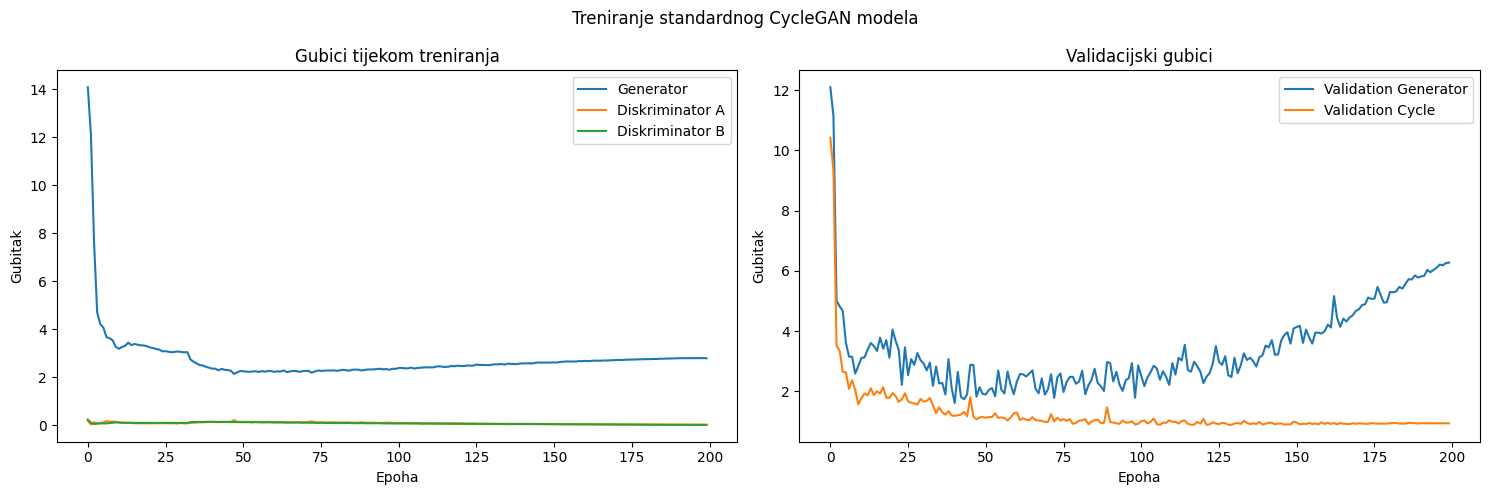

In [23]:
# Vizualizacija krivulja treniranja
plot_training_curves(train_history, "Treniranje standardnog CycleGAN modela")

In [24]:
test_model(G_AB=G_AB, G_BA=G_BA, test_dataloader=test_dataloader, config=config)

Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.08it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8298
  MSE: 0.003768
  PSNR: 24.65 dB

T2 -> T1 translacija:
  SSIM: 0.8675
  MSE: 0.003326
  PSNR: 25.26 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9145
  MSE: 0.001526
  PSNR: 28.28 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9014
  MSE: 0.001843
  PSNR: 27.50 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7303
  MSE: 0.006224
  PSNR: 22.47 dB

T2 -> T1 translacija:
  SSIM: 0.7836
  MSE: 0.005493
  PSNR: 23.08 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8569
  MSE: 0.002521
  PSNR: 26.10 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8353
  MSE: 0.003045
  PSNR: 25.32 dB


Vizualizacija rezultata na test setu:


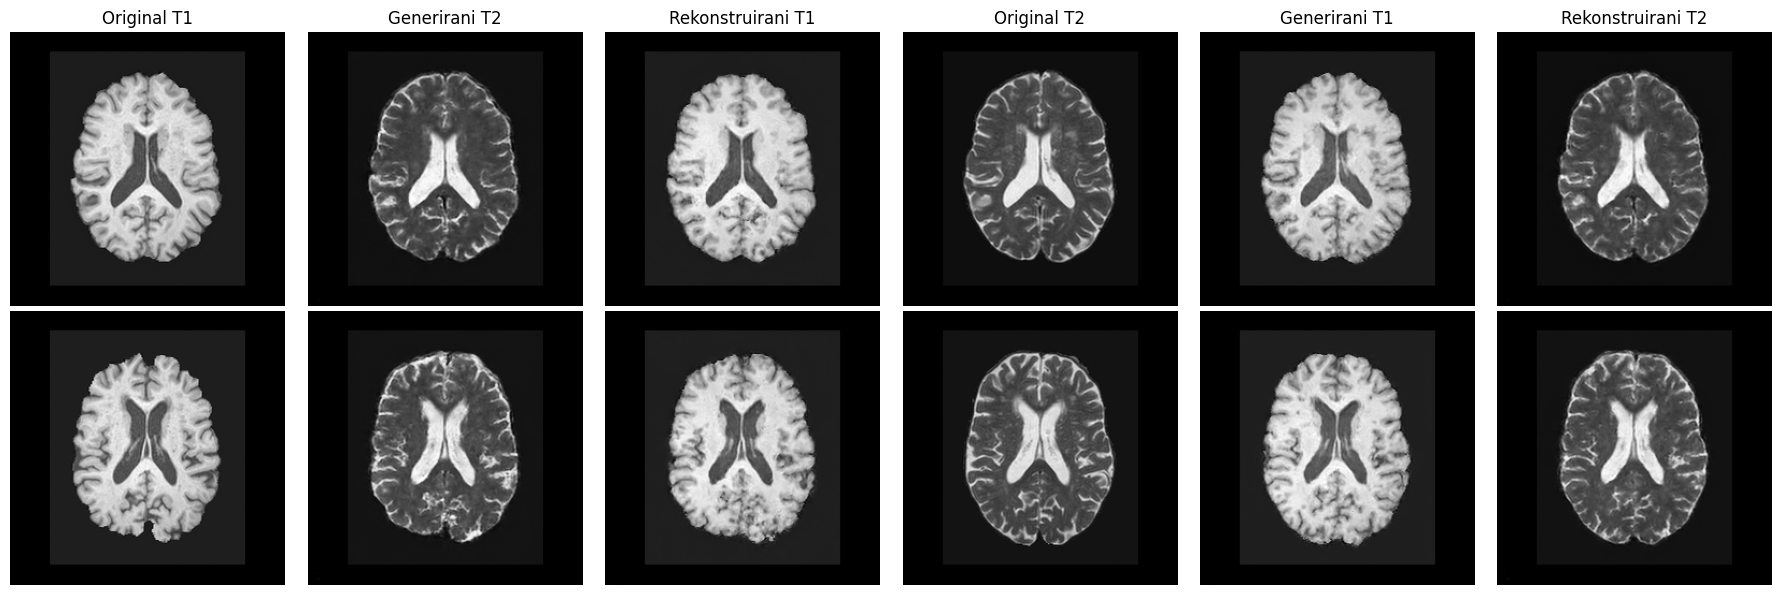

In [28]:
print("Vizualizacija rezultata na test setu:")
visualize_results(G_AB, G_BA, test_dataloader, num_samples=2, config=config)

In [31]:
best_G_AB = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)
best_G_BA = VGG19Generator(config.input_channels, config.output_channels, config.ngf).to(config.device)

# Putanje do najboljih modela
best_G_AB_path = f"{config.checkpoints_dir}/G_AB_best.pth"
best_G_BA_path = f"{config.checkpoints_dir}/G_BA_best.pth"
best_G_AB.load_state_dict(torch.load(best_G_AB_path, map_location=config.device))
best_G_BA.load_state_dict(torch.load(best_G_BA_path, map_location=config.device))

<All keys matched successfully>

In [32]:
print("Testiranje najboljih modela:")
test_model(best_G_AB, best_G_BA, test_dataloader, config)

Testiranje najboljih modela:


Evaluacija modela: 100%|██████████| 44/44 [00:05<00:00,  8.00it/s]


=== Rezultati evaluacije ===
T1 -> T2 translacija:
  SSIM: 0.8320
  MSE: 0.003736
  PSNR: 24.71 dB

T2 -> T1 translacija:
  SSIM: 0.8701
  MSE: 0.003314
  PSNR: 25.33 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.9255
  MSE: 0.001301
  PSNR: 28.93 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.9106
  MSE: 0.001624
  PSNR: 28.04 dB

=== Rezultati evaluacije (fiksni crop) ===
T1 -> T2 translacija:
  SSIM: 0.7365
  MSE: 0.006155
  PSNR: 22.55 dB

T2 -> T1 translacija:
  SSIM: 0.7884
  MSE: 0.005475
  PSNR: 23.15 dB

T1 -> T2 -> T1 rekonstrukcija:
  SSIM: 0.8754
  MSE: 0.002149
  PSNR: 26.75 dB

T2 -> T1 -> T2 rekonstrukcija:
  SSIM: 0.8536
  MSE: 0.002670
  PSNR: 25.88 dB


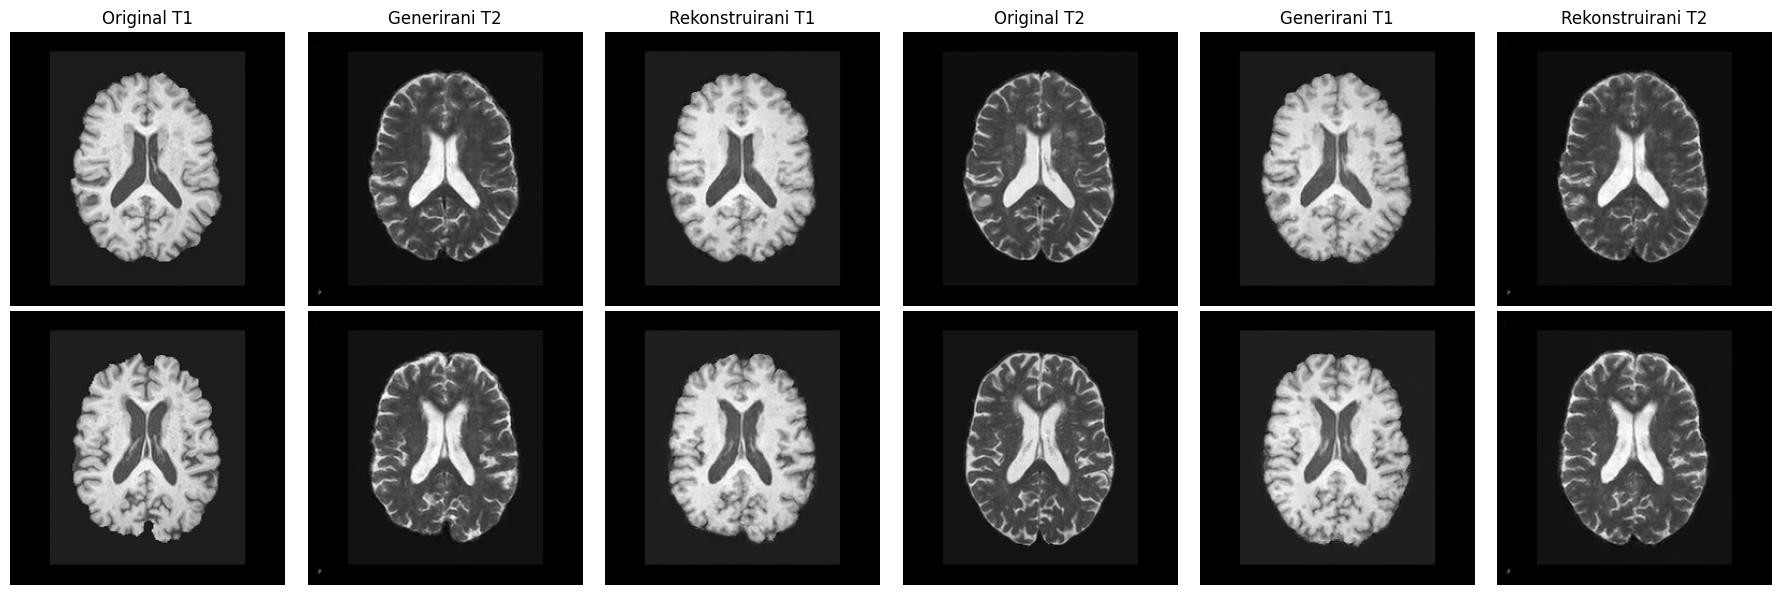

In [34]:
visualize_results(
    best_G_AB, best_G_BA, test_dataloader, num_samples=2, config=config
)